In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy import stats
import warnings
import json
from pathlib import Path
import time
import random
import tensorflow as tf

warnings.filterwarnings('ignore')

# Configuración de semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Librerías importadas correctamente")
print(f"Semilla establecida: {SEED}")

2025-11-25 22:18:42.056849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 22:18:42.057082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 22:18:42.085044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Librerías importadas correctamente
Semilla establecida: 42


2025-11-25 22:18:42.627760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 22:18:42.627957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 1. Carga y Preparación de Datos

In [2]:
# Carga de datos
base = Path('.')
candidates = list(base.glob('**/Tasa*colombiano*.*'))
if not candidates:
    raise FileNotFoundError('No se encontró el archivo de tasa de cambio en el repositorio')
file_path = candidates[0]
print(f'Usando archivo: {file_path}')

if file_path.suffix.lower() in ('.xls', '.xlsx'):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path, encoding='latin1', sep=';')

print(f"Dataset cargado: {df.shape}")

Usando archivo: Tasa de cambio del peso colombiano .xlsx
Dataset cargado: (8862, 18)
Dataset cargado: (8862, 18)


In [3]:
# Preprocesamiento
df_clean = df.iloc[8857-730:8857]
df_clean = df_clean.reset_index(drop=True)

df_preprocessed = df_clean[['periodo', 'trm']]
df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
df_preprocessed['segunda_dif'] = df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)

# Estadísticas para normalización
min_diff = df_preprocessed['primera_dif'].min()
max_diff = df_preprocessed['primera_dif'].max()
mean_diff = df_preprocessed['primera_dif'].mean()
std_diff = df_preprocessed['primera_dif'].std()
min_trm = df_preprocessed['trm'].min()
max_trm = df_preprocessed['trm'].max()

# Transformaciones
df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
df_preprocessed['trans_max_min_trm'] = (df_preprocessed['trm'] - min_trm) / (max_trm - min_trm)
df_preprocessed['primera_dif_trans_max_min_trm'] = df_preprocessed['trans_max_min_trm'].diff()

# Rezagos
df_preprocessed['y_t'] = df_preprocessed['estandarizacion']
df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
df_preprocessed['y_t-2'] = df_preprocessed['y_t-1'].shift(1)
df_preprocessed['y_t-3'] = df_preprocessed['y_t-2'].shift(1)

# Promedios móviles
df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
df_preprocessed['m_3'] = df_preprocessed['y_t'].rolling(window=4, min_periods=4).mean()

# Limpieza de nulos
df_preprocessed.dropna(inplace=True)

print(f"Dataset preprocesado: {df_preprocessed.shape}")
print(f"Valores nulos: {df_preprocessed.isnull().sum().sum()}")

Dataset preprocesado: (726, 15)
Valores nulos: 0


In [4]:
# Preparación de X e y
y = df_preprocessed['y_t']
X = df_preprocessed[['y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"\nPrimeras filas de X:")
display(X.head())

Shape of X: (726, 6)
Shape of y: (726,)

Primeras filas de X:


,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,-0.120222,-2.435930,-1.565010,-0.150111,-0.912051,-1.075291
5,-0.180000,-0.120222,-2.435930,-0.181993,-0.161402,-0.730034
6,-0.183985,-0.180000,-0.120222,0.182500,0.061667,0.016194
7,0.548985,-0.183985,-0.180000,1.575174,0.988787,0.696591
8,2.601363,0.548985,-0.183985,1.571342,1.230556,0.876921


## 2. Funciones de Evaluación de Residuales

In [5]:
def check_zero_mean(residuals, alpha=0.05):
    """
    Verifica si la media de los residuales es estadísticamente cero.
    Retorna: (cumple: bool, p_value: float, mean: float)
    """
    t_stat, p_value = stats.ttest_1samp(residuals, 0)
    cumple = p_value > alpha
    return cumple, p_value, residuals.mean()

def check_no_autocorrelation(residuals, lags=[10, 20], alpha=0.05):
    """
    Verifica ausencia de autocorrelación usando Ljung-Box.
    Retorna: (cumple: bool, p_values: dict)
    """
    p_values = {}
    cumple = True
    
    for lag in lags:
        lb_test = acorr_ljungbox(residuals, lags=[lag], return_df=True)
        p_val = lb_test['lb_pvalue'].values[0]
        p_values[f'lag_{lag}'] = p_val
        if p_val <= alpha:
            cumple = False
    
    return cumple, p_values

def check_normality(residuals, alpha=0.05):
    """
    Verifica normalidad usando Shapiro-Wilk.
    Retorna: (cumple: bool, p_value: float)
    """
    shapiro_stat, p_value = stats.shapiro(residuals)
    cumple = p_value > alpha
    return cumple, p_value

def check_homoscedasticity(residuals, max_lag=20, alpha=0.05):
    """
    Verifica homocedasticidad usando test ARCH.
    Retorna: (cumple: bool, n_arch_effects: int, first_arch_lag: int or None)
    """
    arch_effects = []
    first_arch_lag = None
    
    for lag in range(1, max_lag + 1):
        test_result = het_arch(residuals, nlags=lag)
        p_value = test_result[1]
        
        if p_value < alpha:
            arch_effects.append(lag)
            if first_arch_lag is None:
                first_arch_lag = lag
    
    cumple = len(arch_effects) == 0
    return cumple, len(arch_effects), first_arch_lag

def evaluate_residuals(residuals, verbose=False):
    """
    Evaluación completa de residuales.
    Retorna diccionario con resultados de todos los tests.
    """
    results = {}
    
    # Test 1: Media cero
    zero_mean_ok, zero_mean_pval, mean_val = check_zero_mean(residuals)
    results['zero_mean'] = {
        'cumple': zero_mean_ok,
        'p_value': zero_mean_pval,
        'mean': mean_val
    }
    
    # Test 2: No autocorrelación
    no_autocorr_ok, autocorr_pvals = check_no_autocorrelation(residuals)
    results['no_autocorrelation'] = {
        'cumple': no_autocorr_ok,
        'p_values': autocorr_pvals
    }
    
    # Test 3: Normalidad (opcional)
    normality_ok, normality_pval = check_normality(residuals)
    results['normality'] = {
        'cumple': normality_ok,
        'p_value': normality_pval
    }
    
    # Test 4: Homocedasticidad
    homosced_ok, n_arch, first_arch = check_homoscedasticity(residuals)
    results['homoscedasticity'] = {
        'cumple': homosced_ok,
        'n_arch_effects': n_arch,
        'first_arch_lag': first_arch
    }
    
    # Criterios de aceptación
    results['cumple_prioritarios'] = (
        results['zero_mean']['cumple'] and 
        results['no_autocorrelation']['cumple'] and 
        results['homoscedasticity']['cumple']
    )
    
    results['cumple_todos'] = (
        results['cumple_prioritarios'] and 
        results['normality']['cumple']
    )
    
    if verbose:
        print(f"  ✓ Media cero: {zero_mean_ok} (p={zero_mean_pval:.4f})")
        print(f"  ✓ No autocorrelación: {no_autocorr_ok}")
        print(f"  ✓ Normalidad: {normality_ok} (p={normality_pval:.4f})")
        print(f"  ✓ Homocedasticidad: {homosced_ok} (ARCH effects: {n_arch})")
        print(f"  → Cumple prioritarios: {results['cumple_prioritarios']}")
    
    return results

print("Funciones de evaluación definidas correctamente")

Funciones de evaluación definidas correctamente


## 3. Definición del Espacio de Búsqueda

In [6]:
architectures = [
    # Redes poco profundas
    [16, 8],
    [32, 16],
    [64, 32],
    
    # Redes moderadas (3 capas)
    [32, 16, 8],
    [64, 32, 16],
    [128, 64, 32],
]

# Funciones de activación
activations = ['relu', 'tanh']

# Optimizadores
optimizers = [
    {'name': 'adam', 'lr': 0.001},
    {'name': 'adam', 'lr': 0.0001},
]

# Dropout rates
dropout_rates = [0.0, 0.2]

# Épocas
epochs_list = [200]

# Batch sizes
batch_sizes = [16, 32]

print(f"Espacio de búsqueda definido:")
print(f"  - Arquitecturas: {len(architectures)}")
print(f"  - Activaciones: {len(activations)}")
print(f"  - Optimizadores: {len(optimizers)}")
print(f"  - Dropout rates: {len(dropout_rates)}")
print(f"  - Épocas: {len(epochs_list)}")
print(f"  - Batch sizes: {len(batch_sizes)}")
print(f"\nTotal de combinaciones posibles: {len(architectures) * len(activations) * len(optimizers) * len(dropout_rates) * len(epochs_list) * len(batch_sizes)}")

Espacio de búsqueda definido:
  - Arquitecturas: 6
  - Activaciones: 2
  - Optimizadores: 2
  - Dropout rates: 2
  - Épocas: 1
  - Batch sizes: 2

Total de combinaciones posibles: 96


## 4. Función para Crear y Entrenar Modelos

In [7]:
def create_model(architecture, activation, optimizer_config, dropout_rate, input_shape):
    """
    Crea un modelo de red neuronal con la configuración especificada.
    """
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    
    for i, units in enumerate(architecture):
        model.add(Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='linear'))
    
    # Configurar optimizador
    if optimizer_config['name'] == 'adam':
        optimizer = Adam(learning_rate=optimizer_config['lr'])
    elif optimizer_config['name'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=optimizer_config['lr'])
    else:
        optimizer = SGD(learning_rate=optimizer_config['lr'])
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

def train_and_evaluate_model(config, X_train, y_train, verbose=0):
    """
    Entrena un modelo con la configuración dada y evalúa sus residuales.
    Retorna: diccionario con métricas y cumplimiento de criterios.
    """
    try:
        # Crear modelo
        model = create_model(
            architecture=config['architecture'],
            activation=config['activation'],
            optimizer_config=config['optimizer'],
            dropout_rate=config['dropout'],
            input_shape=X_train.shape[1]
        )
        
        # Entrenar (sin validation split)
        history = model.fit(
            X_train, y_train,
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=0
        )
        
        # Predicciones
        y_pred = model.predict(X_train, verbose=0)
        
        # Calcular residuales
        residuals = y_train - y_pred.flatten()
        
        # Evaluación del modelo
        mse = model.evaluate(X_train, y_train, verbose=0)[0]
        mae = model.evaluate(X_train, y_train, verbose=0)[1]
        
        # Evaluar residuales
        residual_results = evaluate_residuals(residuals, verbose=verbose)
        
        return {
            'model': model,
            'mse': mse,
            'mae': mae,
            'residuals': residuals,
            'residual_tests': residual_results,
            'history': history,
            'success': True
        }
    
    except Exception as e:
        if verbose:
            print(f"  ❌ Error durante entrenamiento: {str(e)}")
        return {
            'model': None,
            'mse': float('inf'),
            'mae': float('inf'),
            'residuals': None,
            'residual_tests': None,
            'history': None,
            'success': False,
            'error': str(e)
        }

print("Funciones de creación y entrenamiento definidas")

Funciones de creación y entrenamiento definidas


## 5. Grid Search

⚠️ **ADVERTENCIA**: Este proceso puede tomar varias horas dependiendo del hardware.

Para acelerar la búsqueda, se puede:
- Reducir el número de arquitecturas
- Reducir épocas
- Limitar combinaciones de hiperparámetros

In [15]:
# Configuración de búsqueda (ajustar según necesidades)
# Para búsqueda rápida, descomentar las siguientes líneas:
# architectures = architectures[:5]  # Solo las primeras 5 arquitecturas
# epochs_list = [100]  # Solo 100 épocas
# batch_sizes = [32]  # Solo batch size 32

print("Configuración de Grid Search:")
print(f"  - Total arquitecturas: {len(architectures)}")
print(f"  - Total activaciones: {len(activations)}")
print(f"  - Total optimizadores: {len(optimizers)}")
print(f"  - Total dropout rates: {len(dropout_rates)}")
print(f"  - Total épocas: {len(epochs_list)}")
print(f"  - Total batch sizes: {len(batch_sizes)}")
print(f"\n⚠️ Se entrenarán aproximadamente {len(architectures) * len(activations) * len(optimizers) * len(dropout_rates) * len(epochs_list) * len(batch_sizes)} modelos")

Configuración de Grid Search:
  - Total arquitecturas: 6
  - Total activaciones: 2
  - Total optimizadores: 2
  - Total dropout rates: 2
  - Total épocas: 1
  - Total batch sizes: 2

⚠️ Se entrenarán aproximadamente 96 modelos


In [9]:
# Inicializar resultados
all_results = []
best_models = {
    'cumple_prioritarios': [],  # Modelos que cumplen criterios 1, 2 y 4
    'cumple_todos': []  # Modelos que cumplen todos los criterios (1, 2, 3 y 4)
}

total_combinations = len(architectures) * len(activations) * len(optimizers) * len(dropout_rates) * len(epochs_list) * len(batch_sizes)
current_iteration = 0
start_time = time.time()

print("="*80)
print("INICIANDO GRID SEARCH")
print("="*80)

# Grid Search
for arch in architectures:
    for activation in activations:
        for optimizer in optimizers:
            for dropout in dropout_rates:
                for epochs in epochs_list:
                    for batch_size in batch_sizes:
                        current_iteration += 1
                        
                        config = {
                            'architecture': arch,
                            'activation': activation,
                            'optimizer': optimizer,
                            'dropout': dropout,
                            'epochs': epochs,
                            'batch_size': batch_size
                        }
                        
                        # Progreso
                        if current_iteration % 10 == 0 or current_iteration == 1:
                            elapsed = time.time() - start_time
                            avg_time = elapsed / current_iteration
                            remaining = avg_time * (total_combinations - current_iteration)
                            print(f"\n[{current_iteration}/{total_combinations}] Progreso: {100*current_iteration/total_combinations:.1f}%")
                            print(f"  Tiempo transcurrido: {elapsed/60:.1f} min | Estimado restante: {remaining/60:.1f} min")
                            print(f"  Config: arch={arch}, act={activation}, opt={optimizer['name']}, dropout={dropout}, epochs={epochs}, batch={batch_size}")
                        
                        # Entrenar y evaluar
                        result = train_and_evaluate_model(config, X, y, verbose=0)
                        
                        if result['success']:
                            # Guardar resultado completo
                            result_summary = {
                                'config': config,
                                'mse': result['mse'],
                                'mae': result['mae'],
                                'residual_tests': result['residual_tests'],
                                'cumple_prioritarios': result['residual_tests']['cumple_prioritarios'],
                                'cumple_todos': result['residual_tests']['cumple_todos']
                            }
                            all_results.append(result_summary)
                            
                            # Si cumple criterios prioritarios, guardar modelo
                            if result['residual_tests']['cumple_prioritarios']:
                                model_info = {
                                    'config': config,
                                    'model': result['model'],
                                    'mse': result['mse'],
                                    'mae': result['mae'],
                                    'residual_tests': result['residual_tests']
                                }
                                best_models['cumple_prioritarios'].append(model_info)
                                print(f"  ✅ Modelo cumple criterios PRIORITARIOS - MSE: {result['mse']:.6f}")
                                
                                # Si además cumple todos
                                if result['residual_tests']['cumple_todos']:
                                    best_models['cumple_todos'].append(model_info)
                                    print(f"  🌟 Modelo cumple TODOS los criterios - MSE: {result['mse']:.6f}")

total_time = time.time() - start_time
print("\n" + "="*80)
print("GRID SEARCH COMPLETADO")
print("="*80)
print(f"Tiempo total: {total_time/60:.1f} minutos")
print(f"Modelos evaluados: {len(all_results)}")
print(f"Modelos que cumplen criterios PRIORITARIOS: {len(best_models['cumple_prioritarios'])}")
print(f"Modelos que cumplen TODOS los criterios: {len(best_models['cumple_todos'])}")

INICIANDO GRID SEARCH

[1/96] Progreso: 1.0%
  Tiempo transcurrido: 0.0 min | Estimado restante: 0.0 min
  Config: arch=[16, 8], act=relu, opt=adam, dropout=0.0, epochs=200, batch=16


2025-11-25 22:18:43.321946: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.018552

[10/96] Progreso: 10.4%
  Tiempo transcurrido: 1.1 min | Estimado restante: 9.9 min
  Config: arch=[16, 8], act=tanh, opt=adam, dropout=0.0, epochs=200, batch=32

[10/96] Progreso: 10.4%
  Tiempo transcurrido: 1.1 min | Estimado restante: 9.9 min
  Config: arch=[16, 8], act=tanh, opt=adam, dropout=0.0, epochs=200, batch=32
  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.000257
  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.000257

[20/96] Progreso: 20.8%
  Tiempo transcurrido: 2.4 min | Estimado restante: 9.3 min
  Config: arch=[32, 16], act=relu, opt=adam, dropout=0.2, epochs=200, batch=32

[20/96] Progreso: 20.8%
  Tiempo transcurrido: 2.4 min | Estimado restante: 9.3 min
  Config: arch=[32, 16], act=relu, opt=adam, dropout=0.2, epochs=200, batch=32
  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.003207
  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.003207
  ✅ Modelo cumple criterios PRIORITARIOS - MSE: 0.003057
  ✅ 

## 6. Análisis de Resultados

In [10]:
# Ordenar modelos por MSE
if len(best_models['cumple_prioritarios']) > 0:
    best_models['cumple_prioritarios'].sort(key=lambda x: x['mse'])
    
if len(best_models['cumple_todos']) > 0:
    best_models['cumple_todos'].sort(key=lambda x: x['mse'])

print("="*80)
print("TOP 10 MODELOS QUE CUMPLEN CRITERIOS PRIORITARIOS (ordenados por MSE)")
print("="*80)

for i, model_info in enumerate(best_models['cumple_prioritarios'][:10], 1):
    config = model_info['config']
    tests = model_info['residual_tests']
    
    print(f"\n{i}. MSE: {model_info['mse']:.6f} | MAE: {model_info['mae']:.6f}")
    print(f"   Arquitectura: {config['architecture']}")
    print(f"   Activación: {config['activation']} | Optimizador: {config['optimizer']['name']} (lr={config['optimizer']['lr']})")
    print(f"   Dropout: {config['dropout']} | Épocas: {config['epochs']} | Batch: {config['batch_size']}")
    print(f"   Tests: Media cero ✓ | No autocorr ✓ | Normalidad {'✓' if tests['normality']['cumple'] else '✗'} | Homoced ✓")

if len(best_models['cumple_todos']) > 0:
    print("\n" + "="*80)
    print("TOP 5 MODELOS QUE CUMPLEN TODOS LOS CRITERIOS (ordenados por MSE)")
    print("="*80)
    
    for i, model_info in enumerate(best_models['cumple_todos'][:5], 1):
        config = model_info['config']
        print(f"\n{i}. MSE: {model_info['mse']:.6f} | MAE: {model_info['mae']:.6f}")
        print(f"   Arquitectura: {config['architecture']}")
        print(f"   Activación: {config['activation']} | Optimizador: {config['optimizer']['name']} (lr={config['optimizer']['lr']})")
        print(f"   Dropout: {config['dropout']} | Épocas: {config['epochs']} | Batch: {config['batch_size']}")

TOP 10 MODELOS QUE CUMPLEN CRITERIOS PRIORITARIOS (ordenados por MSE)

1. MSE: 0.000167 | MAE: 0.010031
   Arquitectura: [128, 64, 32]
   Activación: relu | Optimizador: adam (lr=0.0001)
   Dropout: 0.0 | Épocas: 200 | Batch: 32
   Tests: Media cero ✓ | No autocorr ✓ | Normalidad ✗ | Homoced ✓

2. MSE: 0.000257 | MAE: 0.007946
   Arquitectura: [16, 8]
   Activación: tanh | Optimizador: adam (lr=0.001)
   Dropout: 0.0 | Épocas: 200 | Batch: 32
   Tests: Media cero ✓ | No autocorr ✓ | Normalidad ✗ | Homoced ✓

3. MSE: 0.000858 | MAE: 0.022519
   Arquitectura: [64, 32, 16]
   Activación: relu | Optimizador: adam (lr=0.0001)
   Dropout: 0.0 | Épocas: 200 | Batch: 32
   Tests: Media cero ✓ | No autocorr ✓ | Normalidad ✗ | Homoced ✓

4. MSE: 0.002091 | MAE: 0.026919
   Arquitectura: [64, 32]
   Activación: tanh | Optimizador: adam (lr=0.0001)
   Dropout: 0.0 | Épocas: 200 | Batch: 16
   Tests: Media cero ✓ | No autocorr ✓ | Normalidad ✗ | Homoced ✓

5. MSE: 0.003057 | MAE: 0.018198
   Arquit

## 7. Guardado de Mejores Modelos

In [11]:
# Crear directorio para guardar modelos
models_dir = Path('./best_models')
models_dir.mkdir(exist_ok=True)

# Guardar top 5 modelos que cumplen criterios prioritarios
print("Guardando mejores modelos...\n")

for i, model_info in enumerate(best_models['cumple_prioritarios'][:5], 1):
    model_name = f"model_prioritarios_rank{i}_mse{model_info['mse']:.6f}"
    model_path = models_dir / f"{model_name}.keras"
    
    # Guardar modelo
    model_info['model'].save(model_path)
    
    # Guardar configuración
    config_path = models_dir / f"{model_name}_config.json"
    config_data = {
        'config': model_info['config'],
        'mse': float(model_info['mse']),
        'mae': float(model_info['mae']),
        'residual_tests': {
            'zero_mean': {
                'cumple': bool(model_info['residual_tests']['zero_mean']['cumple']),
                'p_value': float(model_info['residual_tests']['zero_mean']['p_value']),
                'mean': float(model_info['residual_tests']['zero_mean']['mean'])
            },
            'no_autocorrelation': {
                'cumple': bool(model_info['residual_tests']['no_autocorrelation']['cumple']),
                'p_values': {k: float(v) for k, v in model_info['residual_tests']['no_autocorrelation']['p_values'].items()}
            },
            'normality': {
                'cumple': bool(model_info['residual_tests']['normality']['cumple']),
                'p_value': float(model_info['residual_tests']['normality']['p_value'])
            },
            'homoscedasticity': {
                'cumple': bool(model_info['residual_tests']['homoscedasticity']['cumple']),
                'n_arch_effects': int(model_info['residual_tests']['homoscedasticity']['n_arch_effects']),
                'first_arch_lag': int(model_info['residual_tests']['homoscedasticity']['first_arch_lag']) if model_info['residual_tests']['homoscedasticity']['first_arch_lag'] else None
            }
        }
    }
    
    with open(config_path, 'w') as f:
        json.dump(config_data, f, indent=2)
    
    print(f"✅ Guardado: {model_name}")
    print(f"   Modelo: {model_path}")
    print(f"   Config: {config_path}")

print(f"\n✅ Modelos guardados en: {models_dir.absolute()}")

Guardando mejores modelos...

✅ Guardado: model_prioritarios_rank1_mse0.000167
   Modelo: best_models/model_prioritarios_rank1_mse0.000167.keras
   Config: best_models/model_prioritarios_rank1_mse0.000167_config.json
✅ Guardado: model_prioritarios_rank2_mse0.000257
   Modelo: best_models/model_prioritarios_rank2_mse0.000257.keras
   Config: best_models/model_prioritarios_rank2_mse0.000257_config.json
✅ Guardado: model_prioritarios_rank3_mse0.000858
   Modelo: best_models/model_prioritarios_rank3_mse0.000858.keras
   Config: best_models/model_prioritarios_rank3_mse0.000858_config.json
✅ Guardado: model_prioritarios_rank4_mse0.002091
   Modelo: best_models/model_prioritarios_rank4_mse0.002091.keras
   Config: best_models/model_prioritarios_rank4_mse0.002091_config.json
✅ Guardado: model_prioritarios_rank5_mse0.003057
   Modelo: best_models/model_prioritarios_rank5_mse0.003057.keras
   Config: best_models/model_prioritarios_rank5_mse0.003057_config.json

✅ Modelos guardados en: /run/media

## 8. Análisis Detallado del Mejor Modelo

ANÁLISIS DETALLADO DEL MEJOR MODELO

MSE: 0.000167
MAE: 0.010031

Configuración:
  Arquitectura: [128, 64, 32]
  Activación: relu
  Optimizador: adam (lr=0.0001)
  Dropout: 0.0
  Épocas: 200
  Batch size: 32

Arquitectura del modelo:


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_292 (Dense)               │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,797 (132.02 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,532 (88.02 KB)

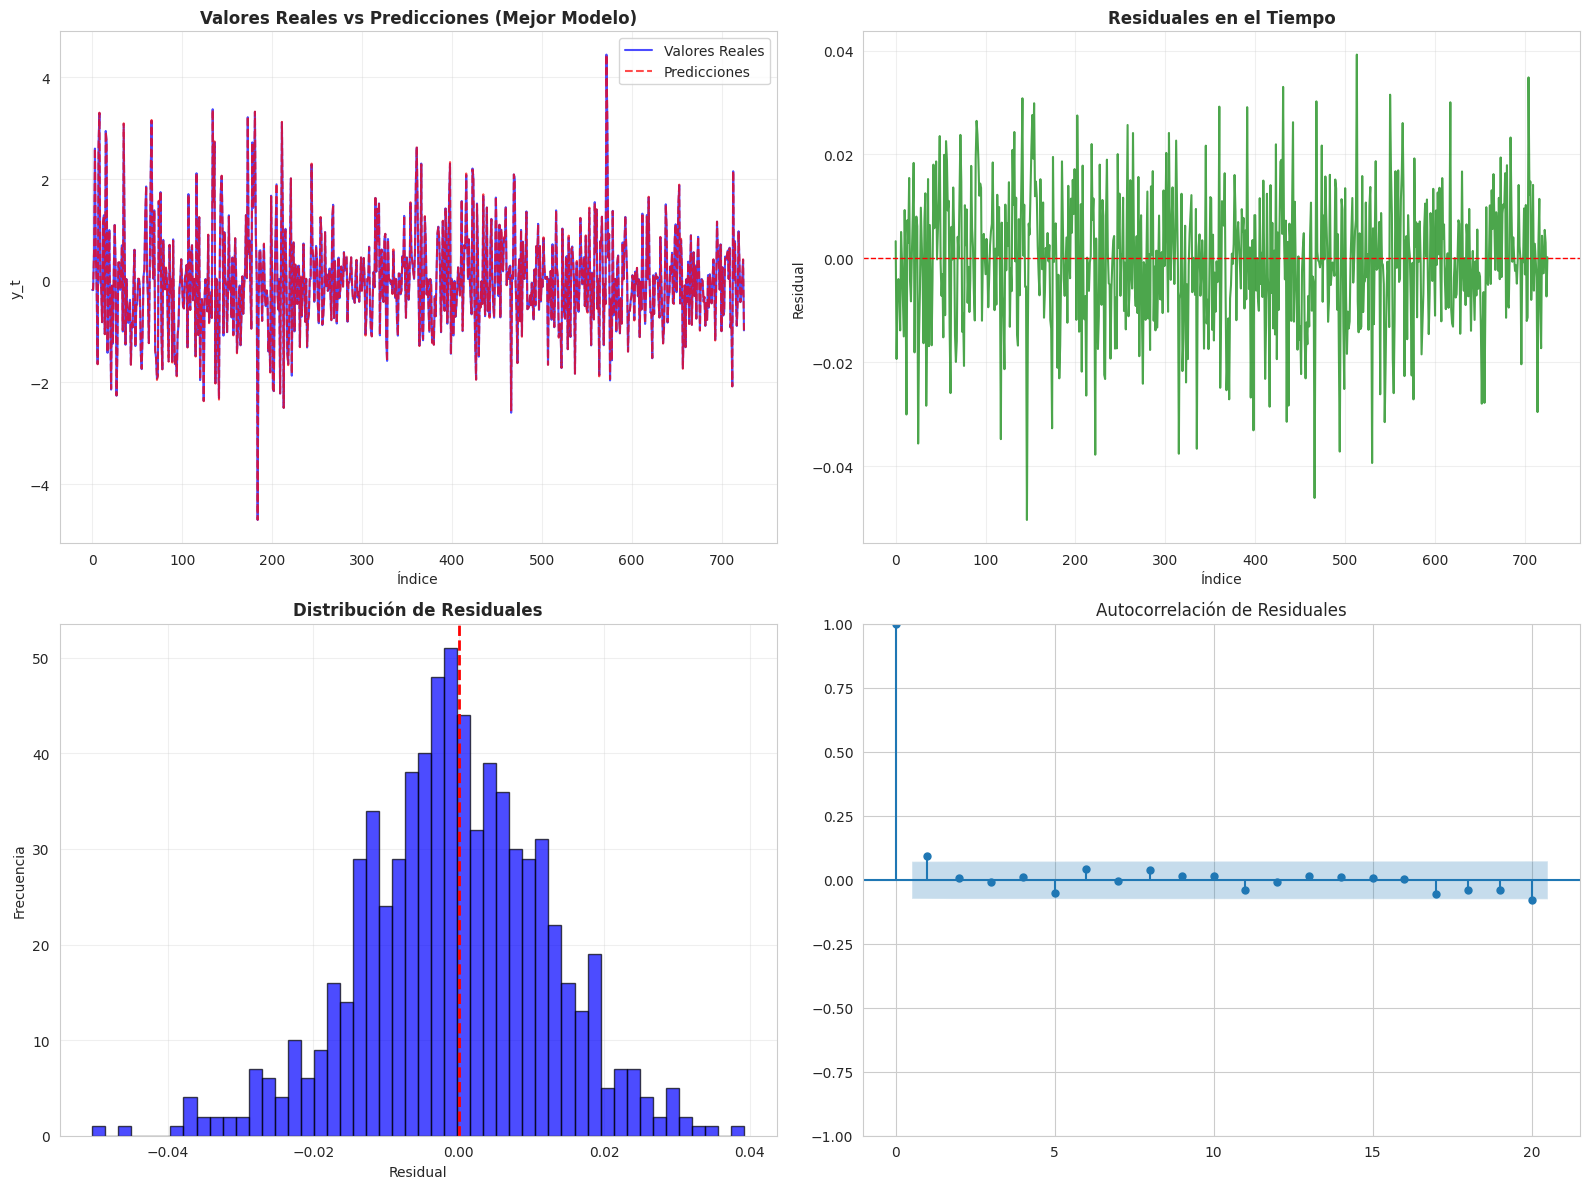

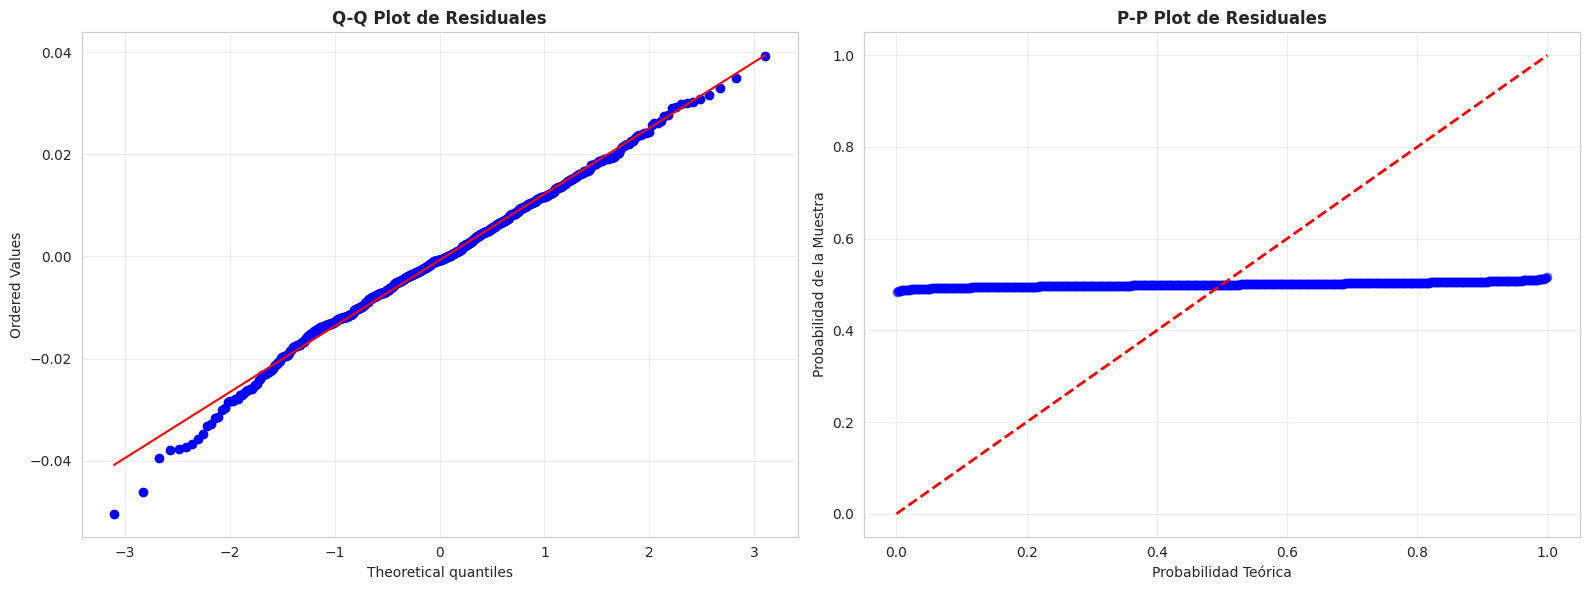


RESULTADOS DETALLADOS DE TESTS DE RESIDUALES

1. Media Cero:
   Cumple: ✅ SÍ
   P-value: 0.131699
   Media: -0.000723

2. No Autocorrelación:
   Cumple: ✅ SÍ
   lag_10: p-value = 0.358127
   lag_20: p-value = 0.346709

3. Normalidad:
   Cumple: ❌ NO
   P-value (Shapiro-Wilk): 0.012436

4. Homocedasticidad:
   Cumple: ✅ SÍ
   Número de efectos ARCH: 0


In [16]:
if len(best_models['cumple_prioritarios']) > 0:
    best_model_info = best_models['cumple_prioritarios'][0]
    best_model = best_model_info['model']
    best_config = best_model_info['config']
    
    print("="*80)
    print("ANÁLISIS DETALLADO DEL MEJOR MODELO")
    print("="*80)
    
    print(f"\nMSE: {best_model_info['mse']:.6f}")
    print(f"MAE: {best_model_info['mae']:.6f}")
    print(f"\nConfiguración:")
    print(f"  Arquitectura: {best_config['architecture']}")
    print(f"  Activación: {best_config['activation']}")
    print(f"  Optimizador: {best_config['optimizer']['name']} (lr={best_config['optimizer']['lr']})")
    print(f"  Dropout: {best_config['dropout']}")
    print(f"  Épocas: {best_config['epochs']}")
    print(f"  Batch size: {best_config['batch_size']}")
    
    # Resumen del modelo
    print("\nArquitectura del modelo:")
    best_model.summary()
    
    # Predicciones y residuales
    y_pred_best = best_model.predict(X, verbose=0)
    residuals_best = y - y_pred_best.flatten()
    
    # Visualización Principal
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Predicciones vs Reales
    axes[0, 0].plot(range(len(y)), y, label='Valores Reales', color='blue', alpha=0.7)
    axes[0, 0].plot(range(len(y)), y_pred_best.flatten(), label='Predicciones', color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Valores Reales vs Predicciones (Mejor Modelo)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Índice')
    axes[0, 0].set_ylabel('y_t')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Residuales
    axes[0, 1].plot(range(len(residuals_best)), residuals_best, color='green', alpha=0.7)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 1].set_title('Residuales en el Tiempo', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Índice')
    axes[0, 1].set_ylabel('Residual')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Histograma de residuales
    axes[1, 0].hist(residuals_best, bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frecuencia')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: ACF de residuales
    plot_acf(residuals_best, lags=20, ax=axes[1, 1], title='Autocorrelación de Residuales')
    
    plt.tight_layout()
    plt.show()
    
    # Visualización de Normalidad (QQ-plot y PP-plot)
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    
    # QQ-plot
    stats.probplot(residuals_best, dist="norm", plot=axes2[0])
    axes2[0].set_title('Q-Q Plot de Residuales', fontsize=12, fontweight='bold')
    axes2[0].grid(True, alpha=0.3)
    
    # PP-plot
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_best, dist="norm")
    axes2[1].plot(stats.norm.cdf(osm), stats.norm.cdf(slope * osm + intercept), 'bo', alpha=0.5)
    axes2[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
    axes2[1].set_xlabel('Probabilidad Teórica')
    axes2[1].set_ylabel('Probabilidad de la Muestra')
    axes2[1].set_title('P-P Plot de Residuales', fontsize=12, fontweight='bold')
    axes2[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tests detallados
    print("\n" + "="*80)
    print("RESULTADOS DETALLADOS DE TESTS DE RESIDUALES")
    print("="*80)
    
    tests = best_model_info['residual_tests']
    
    print(f"\n1. Media Cero:")
    print(f"   Cumple: {'✅ SÍ' if tests['zero_mean']['cumple'] else '❌ NO'}")
    print(f"   P-value: {tests['zero_mean']['p_value']:.6f}")
    print(f"   Media: {tests['zero_mean']['mean']:.6f}")
    
    print(f"\n2. No Autocorrelación:")
    print(f"   Cumple: {'✅ SÍ' if tests['no_autocorrelation']['cumple'] else '❌ NO'}")
    for lag, pval in tests['no_autocorrelation']['p_values'].items():
        print(f"   {lag}: p-value = {pval:.6f}")
    
    print(f"\n3. Normalidad:")
    print(f"   Cumple: {'✅ SÍ' if tests['normality']['cumple'] else '❌ NO'}")
    print(f"   P-value (Shapiro-Wilk): {tests['normality']['p_value']:.6f}")
    
    print(f"\n4. Homocedasticidad:")
    print(f"   Cumple: {'✅ SÍ' if tests['homoscedasticity']['cumple'] else '❌ NO'}")
    print(f"   Número de efectos ARCH: {tests['homoscedasticity']['n_arch_effects']}")
    if tests['homoscedasticity']['first_arch_lag']:
        print(f"   Primer lag con ARCH: {tests['homoscedasticity']['first_arch_lag']}")
else:
    print("❌ No se encontraron modelos que cumplan los criterios prioritarios.")

## 9. Estadísticas Generales del Grid Search

In [13]:
# Convertir resultados a DataFrame para análisis
df_results = pd.DataFrame([
    {
        'architecture': str(r['config']['architecture']),
        'activation': r['config']['activation'],
        'optimizer': r['config']['optimizer']['name'],
        'learning_rate': r['config']['optimizer']['lr'],
        'dropout': r['config']['dropout'],
        'epochs': r['config']['epochs'],
        'batch_size': r['config']['batch_size'],
        'mse': r['mse'],
        'mae': r['mae'],
        'cumple_media_cero': r['residual_tests']['zero_mean']['cumple'],
        'cumple_no_autocorr': r['residual_tests']['no_autocorrelation']['cumple'],
        'cumple_normalidad': r['residual_tests']['normality']['cumple'],
        'cumple_homoced': r['residual_tests']['homoscedasticity']['cumple'],
        'cumple_prioritarios': r['cumple_prioritarios'],
        'cumple_todos': r['cumple_todos']
    }
    for r in all_results
])

print("="*80)
print("ESTADÍSTICAS GENERALES")
print("="*80)

print(f"\nTotal de modelos evaluados: {len(df_results)}")
print(f"\nPorcentaje de modelos que cumplen cada criterio:")
print(f"  Media cero: {100*df_results['cumple_media_cero'].sum()/len(df_results):.1f}%")
print(f"  No autocorrelación: {100*df_results['cumple_no_autocorr'].sum()/len(df_results):.1f}%")
print(f"  Normalidad: {100*df_results['cumple_normalidad'].sum()/len(df_results):.1f}%")
print(f"  Homocedasticidad: {100*df_results['cumple_homoced'].sum()/len(df_results):.1f}%")
print(f"\n  Criterios prioritarios (1,2,4): {100*df_results['cumple_prioritarios'].sum()/len(df_results):.1f}%")
print(f"  Todos los criterios (1,2,3,4): {100*df_results['cumple_todos'].sum()/len(df_results):.1f}%")

print(f"\nEstadísticas de MSE:")
print(f"  Mejor MSE: {df_results['mse'].min():.6f}")
print(f"  Peor MSE: {df_results['mse'].max():.6f}")
print(f"  MSE promedio: {df_results['mse'].mean():.6f}")
print(f"  MSE mediana: {df_results['mse'].median():.6f}")

# Guardar resultados completos
results_path = models_dir / 'grid_search_results.csv'
df_results.to_csv(results_path, index=False)
print(f"\n✅ Resultados completos guardados en: {results_path}")

ESTADÍSTICAS GENERALES

Total de modelos evaluados: 96

Porcentaje de modelos que cumplen cada criterio:
  Media cero: 51.0%
  No autocorrelación: 29.2%
  Normalidad: 1.0%
  Homocedasticidad: 30.2%

  Criterios prioritarios (1,2,4): 9.4%
  Todos los criterios (1,2,3,4): 0.0%

Estadísticas de MSE:
  Mejor MSE: 0.000033
  Peor MSE: 0.138349
  MSE promedio: 0.009887
  MSE mediana: 0.003942

✅ Resultados completos guardados en: best_models/grid_search_results.csv


## 10. Visualizaciones de Análisis

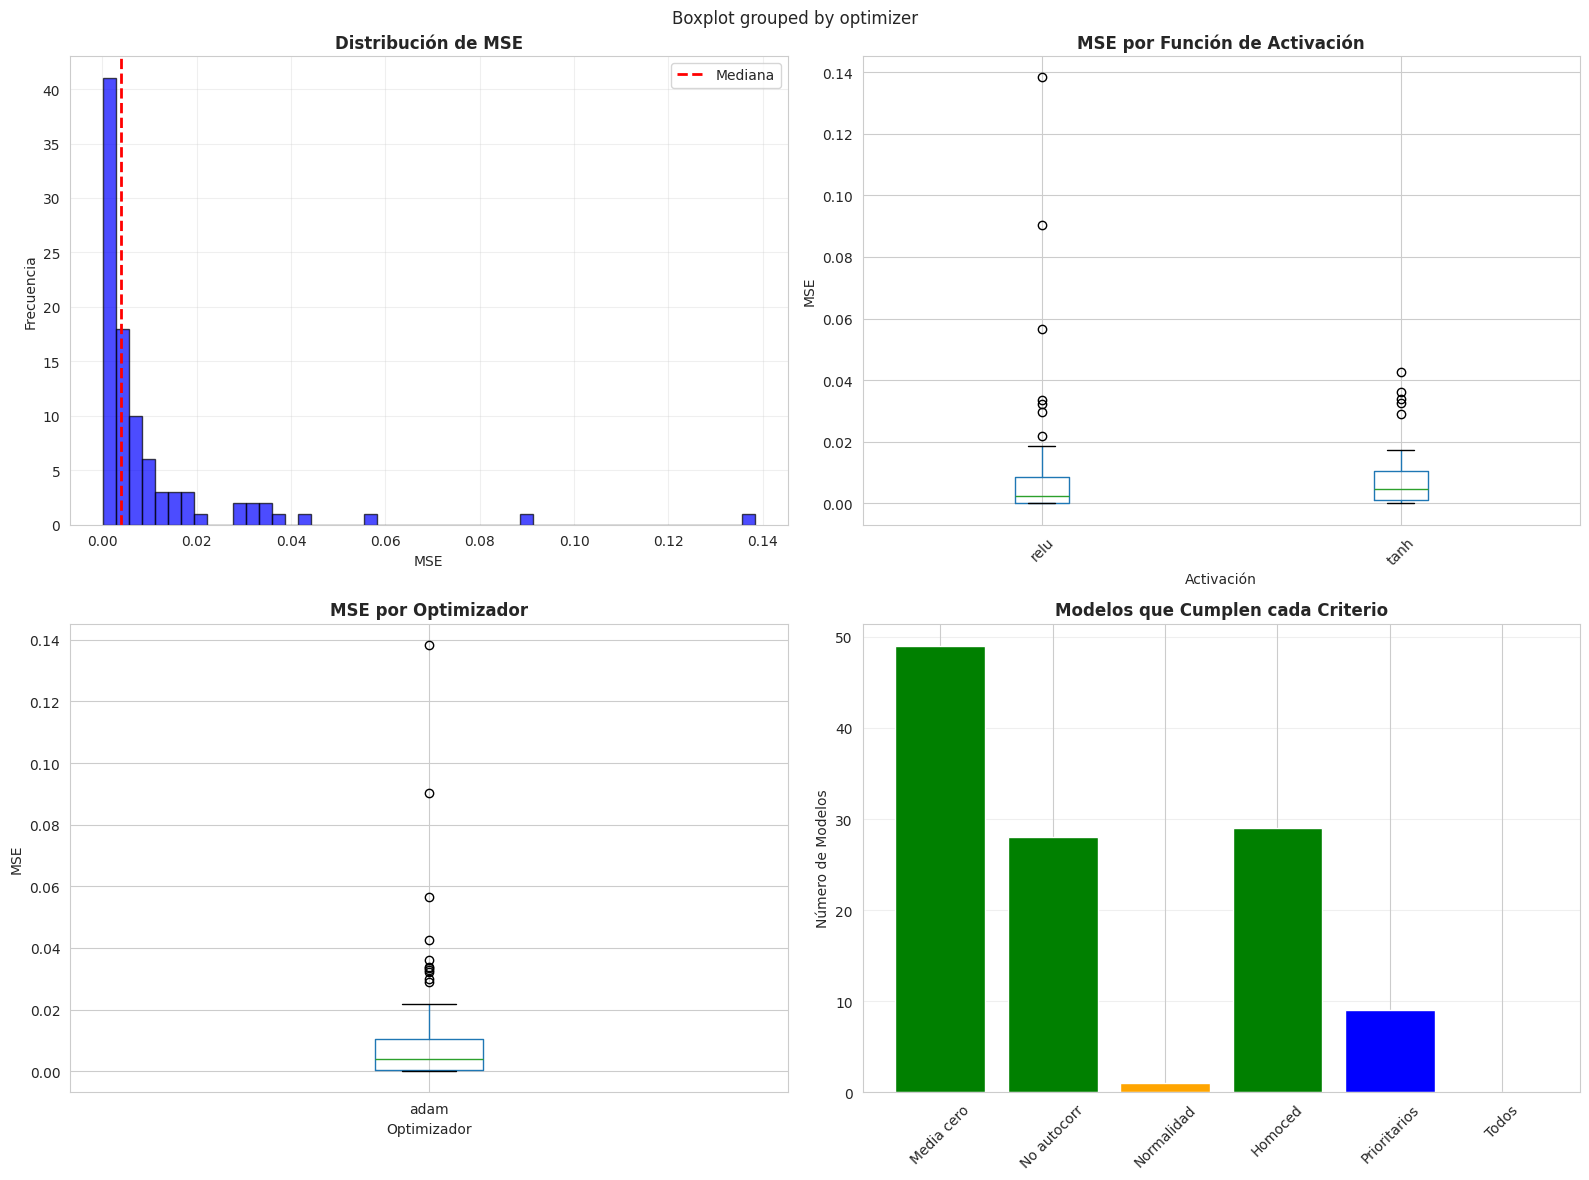

In [14]:
# Gráficos de análisis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribución de MSE
axes[0, 0].hist(df_results['mse'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=df_results['mse'].median(), color='red', linestyle='--', linewidth=2, label='Mediana')
axes[0, 0].set_title('Distribución de MSE', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('MSE')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: MSE por activación
df_results.boxplot(column='mse', by='activation', ax=axes[0, 1])
axes[0, 1].set_title('MSE por Función de Activación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Activación')
axes[0, 1].set_ylabel('MSE')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

# Plot 3: MSE por optimizador
df_results.boxplot(column='mse', by='optimizer', ax=axes[1, 0])
axes[1, 0].set_title('MSE por Optimizador', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Optimizador')
axes[1, 0].set_ylabel('MSE')

# Plot 4: Cumplimiento de criterios
criteria_counts = {
    'Media cero': df_results['cumple_media_cero'].sum(),
    'No autocorr': df_results['cumple_no_autocorr'].sum(),
    'Normalidad': df_results['cumple_normalidad'].sum(),
    'Homoced': df_results['cumple_homoced'].sum(),
    'Prioritarios': df_results['cumple_prioritarios'].sum(),
    'Todos': df_results['cumple_todos'].sum()
}
axes[1, 1].bar(criteria_counts.keys(), criteria_counts.values(), color=['green', 'green', 'orange', 'green', 'blue', 'purple'])
axes[1, 1].set_title('Modelos que Cumplen cada Criterio', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Número de Modelos')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Resumen Final

### Modelos Encontrados

Se han evaluado múltiples configuraciones de redes neuronales y se han identificado los mejores modelos según:

1. **Criterios prioritarios** (Media cero + No autocorrelación + Homocedasticidad)
2. **Menor MSE**

### Modelos Guardados

Los mejores modelos se han guardado en la carpeta `./best_models/` junto con sus configuraciones en formato JSON.

### Próximos Pasos

Para modelos que presentan heterocedasticidad (efectos ARCH), se recomienda:
- Aplicar modelos GARCH sobre los residuales
- Modelar la volatilidad condicional de la serie

### Cargar un Modelo Guardado

```python
from keras.models import load_model
import json

# Cargar modelo
model = load_model('./best_models/model_prioritarios_rank1_mse0.XXXXXX.keras')

# Cargar configuración
with open('./best_models/model_prioritarios_rank1_mse0.XXXXXX_config.json', 'r') as f:
    config = json.load(f)
```